In [31]:
from src.data.make_dataset import load_and_merge_data
import mlflow
import numpy as np
import pandas as pd
import os




base_path = "/Users/adarshgyawali/Desktop/MLOps/MLOPS/MLOPS"
merged_data = load_and_merge_data()
## Dropping Rows and Columns
print("Handling NaN values based on user's specified criteria...")

# Step 1: Calculate NaN percentages for all columns in the current DataFrame
missing_percentages_initial = merged_data.isnull().sum() / len(merged_data) * 100

# Identify columns with more than 50% NaN values to drop entirely
columns_to_drop_entirely = missing_percentages_initial[missing_percentages_initial > 13].index.tolist()

if columns_to_drop_entirely:
    print(f"Dropping columns with > 13% NaN values: {columns_to_drop_entirely}")
    merged_data.drop(columns=columns_to_drop_entirely, inplace=True)
    print(f"Current shape of merged_data after column drops: {merged_data.shape}")
else:
    print("No columns found with > 13% NaN values to drop entirely.")

# Step 2: For remaining columns, drop rows where NaNs exist if the column has <= 50% NaNs
# Recalculate NaN percentages after potential column drops
missing_percentages_after_col_drop = merged_data.isnull().sum() / len(merged_data) * 100
# Show only columns that still contain NaN values (exclude 0% for clarity)
non_zero_missing_percentages = missing_percentages_after_col_drop[missing_percentages_after_col_drop > 0]
print("Columns with remaining NaNs (%):")
print(non_zero_missing_percentages)

# Identify columns with <= 50% NaN values for row-wise dropping
columns_for_row_drop = missing_percentages_after_col_drop[missing_percentages_after_col_drop <= 13].index.tolist()

initial_rows_for_row_drop = merged_data.shape[0]

columns_with_nans_in_subset = []

if columns_for_row_drop:
    print(f"Dropping rows based on NaN values in columns with <= 13% NaNs: {columns_for_row_drop}")
    # Ensure we only consider columns that actually have NaNs among the selected ones for the subset argument
    columns_with_nans_in_subset = [col for col in columns_for_row_drop if merged_data[col].isnull().any()]
    if columns_with_nans_in_subset:
        merged_data.dropna(subset=columns_with_nans_in_subset, inplace=True)
    else:
        print("No NaN values found in the selected columns for row dropping.")
    final_rows_after_row_drop = merged_data.shape[0]
    print(f"Original number of rows for this step: {initial_rows_for_row_drop}")
    print(f"Number of rows after dropping: {final_rows_after_row_drop}")
    print(f"Number of rows dropped in this step: {initial_rows_for_row_drop - final_rows_after_row_drop}")
else:
    print("No columns found with <= 13% NaN values that require row dropping.")
    final_rows_after_row_drop = initial_rows_for_row_drop # No rows dropped if no columns to consider

print("Data cleaning complete.")
print(merged_data.head())


#Mapping Numerical Values for Education
print("Applying Ordinal Encoding to 'EDUCATION' column...")
education_mapping = {
    'SSC': 1,
    '12TH': 2,
    'OTHERS': 2,
    'UNDER GRADUATE': 3,
    'GRADUATE': 3,
    'POST-GRADUATE': 4,
    'PROFESSIONAL': 5
}
merged_data['EDUCATION'] = merged_data['EDUCATION'].map(education_mapping)

# Convert 'Approved_Flag' to numeric based on user's request: P1=1, P2=2, P3=3, P4=0
if merged_data['Approved_Flag'].dtype == 'object':
    # Define the mapping as requested by the user
    approved_flag_mapping = {'P1': 1, 'P2': 2, 'P3': 3, 'P4': 0}
    merged_data['Approved_Flag'] = merged_data['Approved_Flag'].map(approved_flag_mapping)


Loading datasets from local directory...
Handling NaN values based on user's specified criteria...
Dropping columns with > 13% NaN values: ['time_since_first_deliquency', 'time_since_recent_deliquency', 'max_delinquency_level', 'max_deliq_6mts', 'max_deliq_12mts', 'CC_utilization', 'PL_utilization', 'max_unsec_exposure_inPct']
Current shape of merged_data after column drops: (51336, 79)
Columns with remaining NaNs (%):
Age_Oldest_TL                 0.077918
Age_Newest_TL                 0.077918
time_since_recent_payment     8.358657
tot_enq                      12.312997
CC_enq                       12.312997
CC_enq_L6m                   12.312997
CC_enq_L12m                  12.312997
PL_enq                       12.312997
PL_enq_L6m                   12.312997
PL_enq_L12m                  12.312997
time_since_recent_enq        12.312997
enq_L12m                     12.312997
enq_L6m                      12.312997
enq_L3m                      12.312997
pct_currentBal_all_TL         0

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
temp_data=merged_data.copy()
temp_data=temp_data.drop(columns="Approved_Flag")
temp_data=temp_data.select_dtypes(include=['int64','float64'])
vif_data = pd.DataFrame()
vif_data["feature"] = temp_data.columns
vif_data["VIF"] = [variance_inflation_factor(temp_data.values, i) for i in range(temp_data.shape[1])]
vif_data_dict=list(zip(vif_data["feature"] ,vif_data["VIF"]))
corr = temp_data.corr(numeric_only=True)


/Users/adarshgyawali/Desktop/MLOps/MLOPS/venv_for_mlops/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


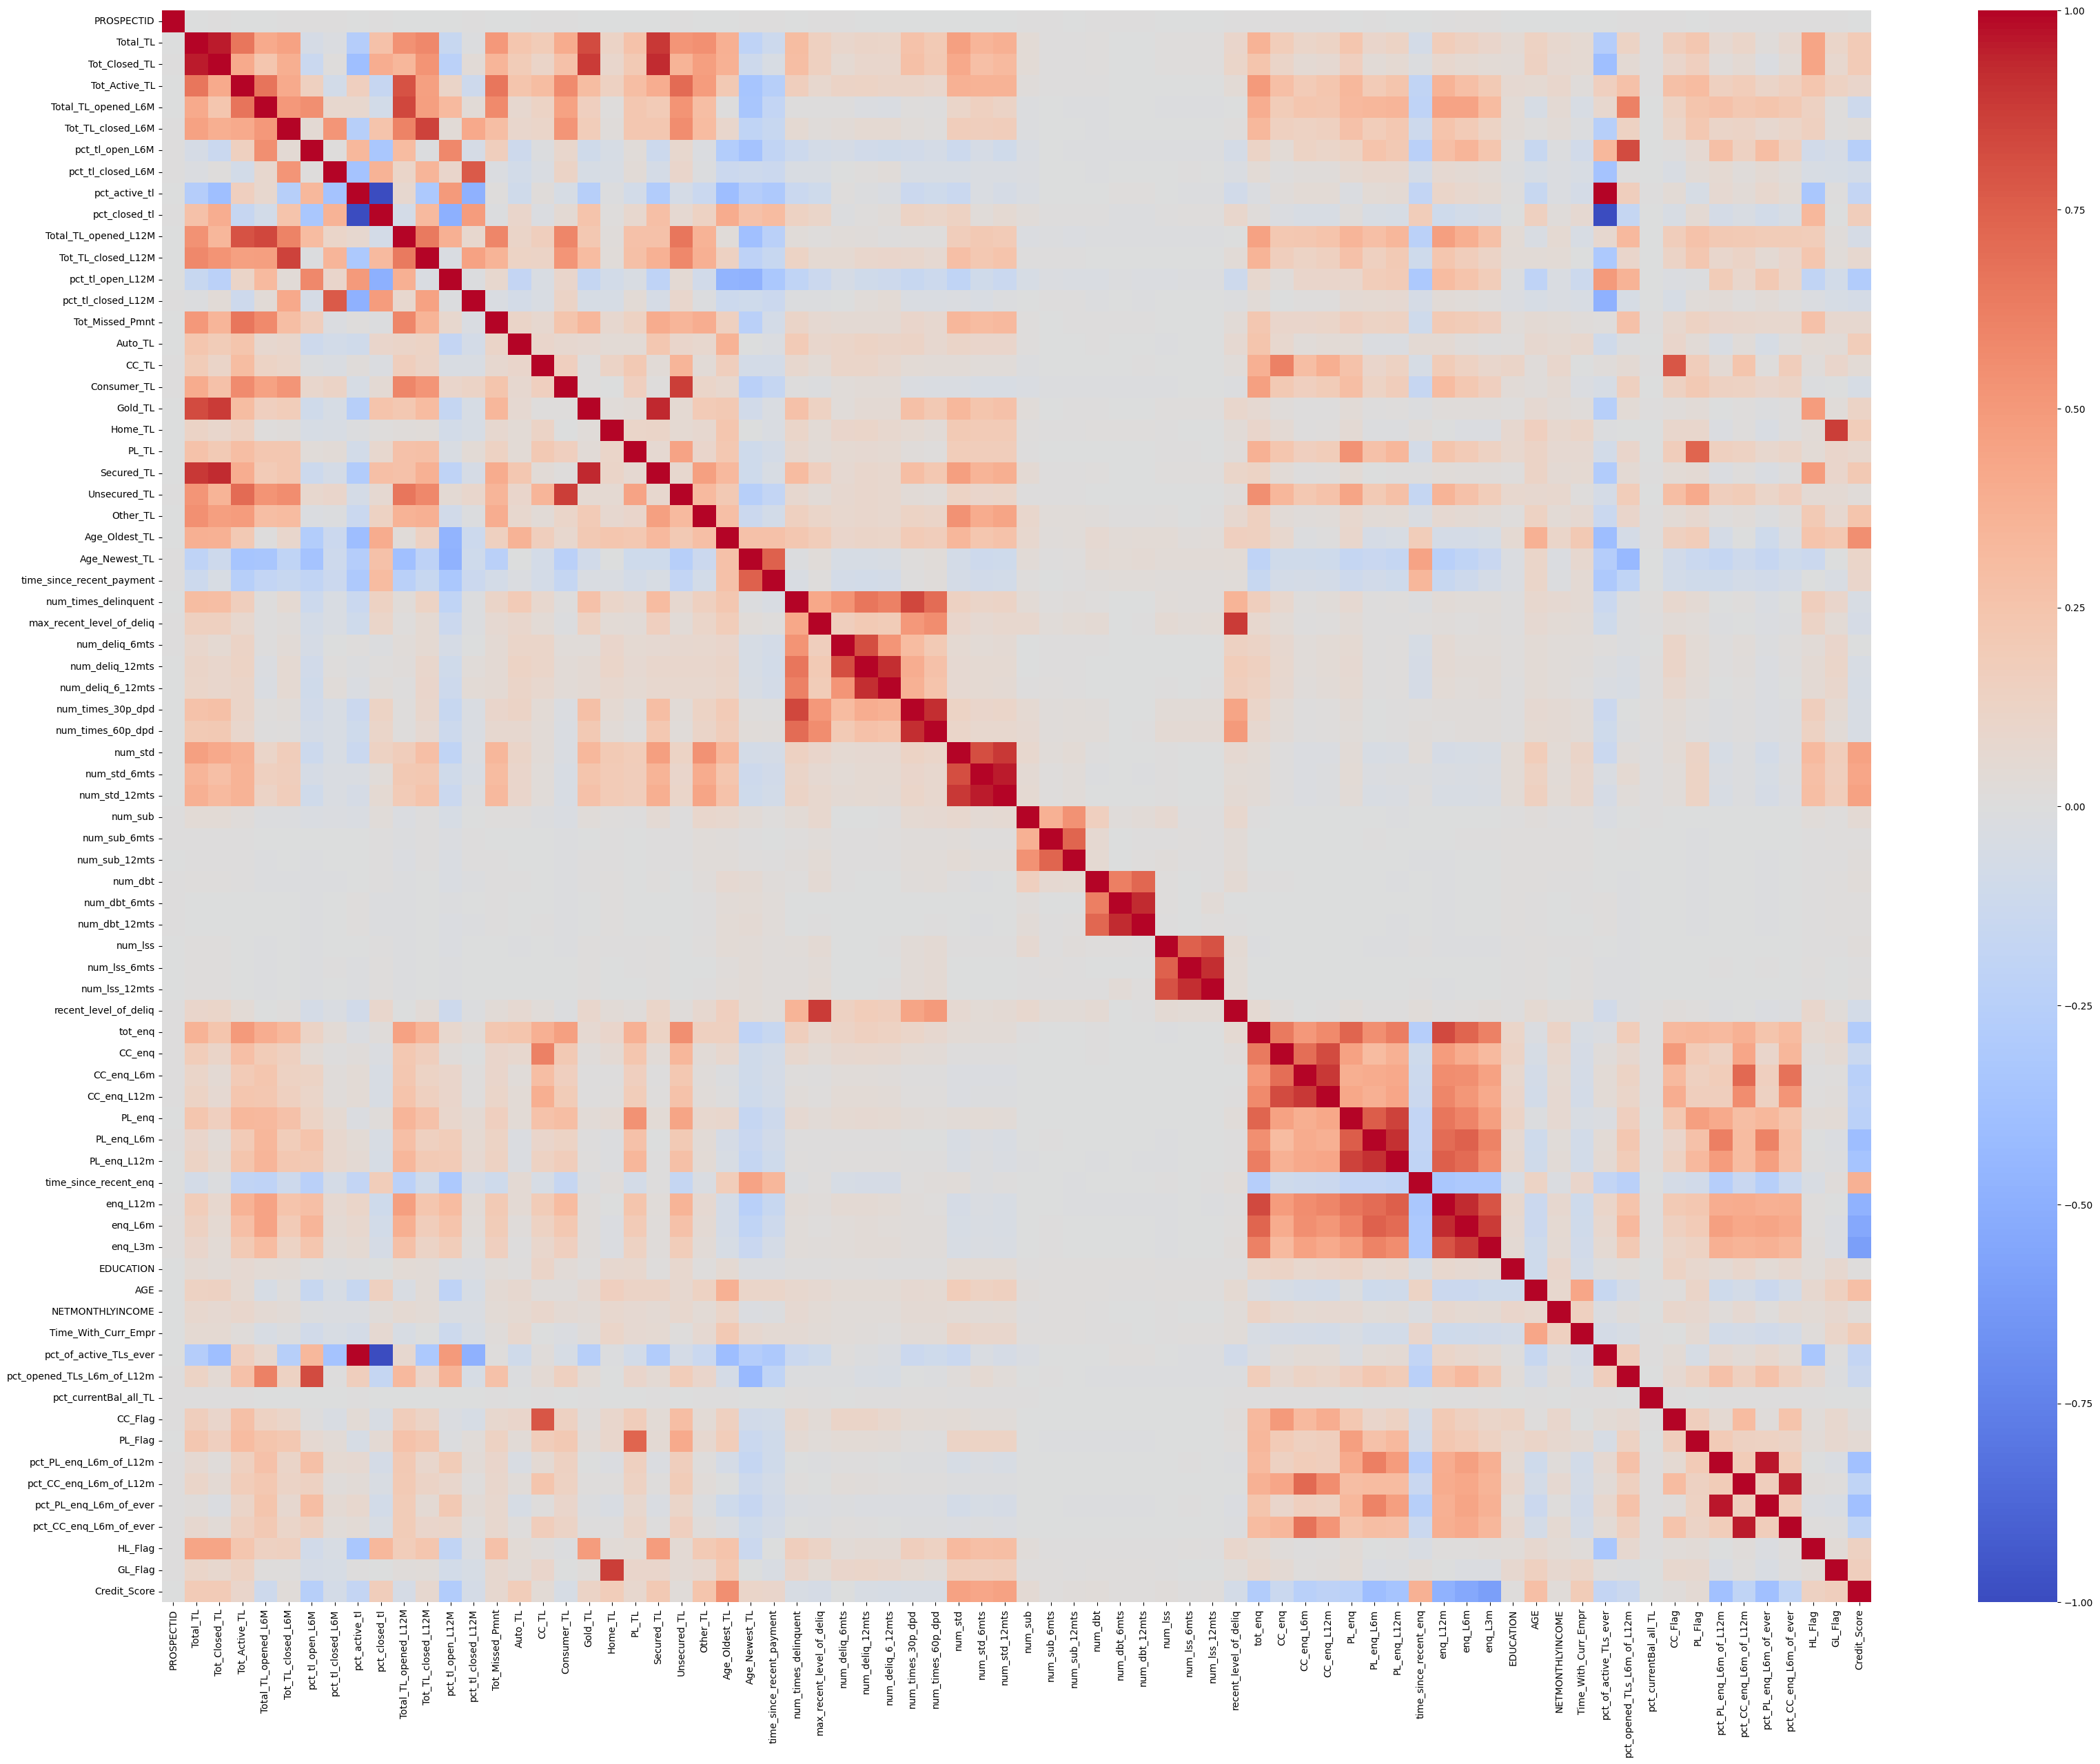

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40, 30))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.savefig("correlation_heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [34]:
print(vif_data_dict)
print(temp_data.shape)


[('PROSPECTID', 1.0014720621264979), ('Total_TL', inf), ('Tot_Closed_TL', inf), ('Tot_Active_TL', inf), ('Total_TL_opened_L6M', 8.386759166892535), ('Tot_TL_closed_L6M', 6.823631651356068), ('pct_tl_open_L6M', 5.344480036764372), ('pct_tl_closed_L6M', 4.223479901340563), ('pct_active_tl', inf), ('pct_closed_tl', 1791.667258010134), ('Total_TL_opened_L12M', 15.200585375611643), ('Tot_TL_closed_L12M', 9.04530371751098), ('pct_tl_open_L12M', 4.010341065517339), ('pct_tl_closed_L12M', 4.946919701436384), ('Tot_Missed_Pmnt', 2.320173387441233), ('Auto_TL', inf), ('CC_TL', inf), ('Consumer_TL', inf), ('Gold_TL', inf), ('Home_TL', inf), ('PL_TL', inf), ('Secured_TL', inf), ('Unsecured_TL', inf), ('Other_TL', inf), ('Age_Oldest_TL', 4.0004607181955505), ('Age_Newest_TL', 3.941802445472082), ('time_since_recent_payment', 2.7357790990100264), ('num_times_delinquent', 6.962002317443997), ('max_recent_level_of_deliq', 4.93894732494436), ('num_deliq_6mts', inf), ('num_deliq_12mts', inf), ('num_deli

In [35]:
columns_to_drop_because_of_high_VIF = []

for item in vif_data_dict:  # item is a tuple like ('colname', VIF_value)
    colname = item[0]
    vif_value = item[1]

    if vif_value > 8 or vif_value == float('inf'):
        columns_to_drop_because_of_high_VIF.append(colname)

print(len(vif_data_dict))
print(columns_to_drop_because_of_high_VIF)


temp_data=temp_data.drop(columns=columns_to_drop_because_of_high_VIF )
print(temp_data.shape)


74
['Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL', 'Total_TL_opened_L6M', 'pct_active_tl', 'pct_closed_tl', 'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'Auto_TL', 'CC_TL', 'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'num_times_30p_dpd', 'num_std_6mts', 'num_std_12mts', 'num_dbt_12mts', 'num_lss_12mts', 'tot_enq', 'CC_enq_L6m', 'CC_enq_L12m', 'PL_enq', 'PL_enq_L6m', 'PL_enq_L12m', 'enq_L12m', 'enq_L6m', 'pct_of_active_TLs_ever', 'pct_PL_enq_L6m_of_L12m', 'pct_CC_enq_L6m_of_L12m', 'pct_PL_enq_L6m_of_ever', 'pct_CC_enq_L6m_of_ever']
(42064, 36)


In [39]:
vif_data_after = pd.DataFrame()
temp_data=temp_data.select_dtypes(include=['int64','float64'])
vif_data_after["feature"] = temp_data.columns
vif_data_after["VIF"] = [variance_inflation_factor(temp_data.values, i) for i in range(temp_data.shape[1])]
vif_data_after_dict=list(zip(vif_data_after["feature"] ,vif_data_after["VIF"]))

In [41]:
print(vif_data_after_dict)

[('PROSPECTID', 3.9863484697817695), ('Tot_TL_closed_L6M', 2.105369989776766), ('pct_tl_open_L6M', 6.97455279095468), ('pct_tl_closed_L6M', 3.6256274666942723), ('pct_tl_open_L12M', 4.9709351315963515), ('pct_tl_closed_L12M', 3.6067003914946314), ('Tot_Missed_Pmnt', 1.7258267782414614), ('Age_Oldest_TL', 4.269076085798279), ('Age_Newest_TL', 5.620046435228903), ('time_since_recent_payment', 3.2091604597329777), ('num_times_delinquent', 2.438714933233962), ('max_recent_level_of_deliq', 5.243855015468525), ('num_times_60p_dpd', 2.4762786456823997), ('num_std', 1.638553018230633), ('num_sub', 1.4885177245795782), ('num_sub_6mts', 2.166300972897043), ('num_sub_12mts', 2.612624335929813), ('num_dbt', 1.7163213139123663), ('num_dbt_6mts', 1.6624684526994364), ('num_lss', 2.2934060579624034), ('num_lss_6mts', 2.280023030646793), ('recent_level_of_deliq', 4.74717555086973), ('CC_enq', 1.6334277198917546), ('time_since_recent_enq', 1.8458598249706715), ('enq_L3m', 1.7594302647661626), ('EDUCATI